In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'led'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_base/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/karger_books_base/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')
        
    from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

    model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        #print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            text_enc = tokenizer.encode(row.text,
                truncation=True,
                max_length=8192,
                return_tensors='pt')
            
            summ_enc = model.generate(
                text_enc,
                min_length = 70,
                max_length = 512,
                length_penalty = 1,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = 3,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)
            
            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            if '<BULL>' in summ:
                summ_bullets = [b for b in summ.split('<BULL>') if len(b)>0]
                for b in summ_bullets:
                    print(fill(b, 100))
                    print()
            else:
                print(fill(summ, 100))
                print()
            
        print('Reference:')
        bullets = [b for b in row.bullets.split('<BULL>') if len(b)>0]
        for b in bullets:
            print(fill(b, 100))
            print()
            
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [8]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **LED on Karger Books**

In [9]:
df_train = pd.read_csv(data_dir+'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir+'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir+'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [14]:
print_examples([
    magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/'],
    df_train)

(9781910797150, 'ch04')

Prediction
/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/ (124 tok):

The use of antiemetics should follow the same principles as those used to treat adults.

Prophylactic control of CINV in patients receiving highly emetogenic chemotherapy (HEC) requires a
combination of a 5-HT RA, dexamethasone and an NK-1 RA (aprepitant) for the prevention of
chemotherapy-induced nausea and vomiting (CINV).

Antiemetic therapy should be started before chemotherapy is administered on day 1 and continued
through the acute and delayed phase for as long as the chemotherapy is emetic (usually 2-3 days).

Reference:
 The primary goal of CINV therapy is the prevention of nausea and vomiting.

 Patients should be individually evaluated for their specific risk factors as well as the level of
anxiety present before the first course of treatment.

 Outcomes are improved by following international guidelines when selecting the antiemetic regim

Prediction
/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/ (123 tok):

The principles of ethical biomedical ethics are at the core of research ethics and should be
carefully considered during the study design phase and ethics review process.

The principle of beneficence focuses on the fair distribution of the benefits and burdens of
research and recruitment protocols that are inclusive of those most likely to benefit from knowledge
gained.

When using third-party commercial apps or measurement tools, the likelihood of a loss of privacy is
100% for all users - yet the consequences will vary. For most people, these will be negligible, but
for a domestic abuse survivor or undocumented migrant, the consequences might be severe.

Reference:
 The principles that guide the ethical conduct of biomedical and behavioral research include:
respect for persons, beneficence, justice (Belmont Report) and respect for law and public interest
(Menlo Report).



##### Print Val Examples

In [15]:
print_examples([
    magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/'],
    df_val)

(9781910797471, 'ch02')

Prediction
/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/ (146 tok):

The sympathetic nervous system (SNS) plays a significant role in the pathophysiology of heart
failure (HF).

Neurohormonal pathways activated in HF are the sympathetic nervous nervous system and the
natriuretic peptide (NP) system.

Neuronal vasoconstriction is an important manifestation of HF, reflecting inactivity, consequences
of circulating substances such as tumor growth factor (TGF)-beta and reduced cardiac output.

Aldosterone (which may be released even in the setting of ACE inhibition) contributes to myocardial
and vascular fibrosis.

The functional status of patients in ACC/AHA class D (with marked symptoms and signs of HF) is
usually limited.

Reference:
 Heart failure (HF) is a disease of response to injury, which is initially appropriate and becomes
inappropriate.

 Inappropriate non-cardiac responses include activation of a variety of 

Prediction
/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/ (214 tok):

High-grade gliomas are highly cellular, with varied nuclear morphology and a scanty perinuclear rim
of cytoplasm.

The diagnosis of glioblastoma requires a multidisciplinary approach, including the use of dynamic
susceptibility contrast-enhanced (DSC, T2) and susceptibility weighted imaging (SWI).

Mutations in the normal metabolite distribution are interpreted as markers of disease processes.

Diseases that are not yet identified, such as choline, N -acetyl aspartate, lactate, lipids, etc.,
should always be considered when assessing glioma infiltration.

Mutation-specific antibodies can be used to identify non-enhancing gliomatous tumors.

A variety of amino acid (non-FDG) tracers have been developed that looks at epigenetic changes
caused by a combination of mutations and the cell of origin.

Multivoxel spectroscopy is the most demanding and increasingly available modalit

##### Print Test Examples

In [16]:
print_examples([
    magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/'],
    df_test)

(9781910797105, 'ch05')

Prediction
/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/ (95 tok):

The neurodevelopmental hypothesis of schizophrenia is based on a static lesion in the maturational
stage of the brain.

Drug use increases the risk of developing schizophrenia.

The risk is further increased if minor psychotic symptoms pre-exist and if cannabis use starts early
in adolescence.

There is emerging evidence for the role of non-biological risk factors in schizophrenia, such as the
effects of urban upbringing and of ethnicity, as noted in Chapter 3.

Reference:
 Early neurodevelopmental, non-genetic risk factors exist for schizophrenia.

 Like genetic factors, environmental factors are many and varied.

 Birth complications increase the child's risk of schizophrenia in later life fourfold.

 Psychosocial risk factors are being re-established as important risk factors.

 Cannabis use increases the risk of schizophrenia as well as relapse.


Prediction
/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/ (106 tok):

Binge eating disorder (BED) is associated with obstructive sleep apnea and restless legs syndrome.

Behavioral therapy (CBT) is a key component of long-term obesity management.

A food and activity diary should clarify eating patterns and behaviors, particularly events that
trigger eating, with a view to changing those patterns once they have been identified, at a
realistic rate of improvement.

Stimulus control: avoiding situations that lead to harmful behavior, and promoting situations that
influence healthy activity.

Reference:
 Behavioral therapy, alongside diet and lifestyle advice, is one of the three key components of
obesity management.

 A person's degree of motivation and expectations should be assessed.

 Techniques include goal setting, self-monitoring and stimulus control.

 Binge eating disorder and night eating syndrome are specific eating disorders and shou

##### Summarize Test

In [17]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    model.config.max_length = 512
    model.config.min_length = 90
    
    input_ids = tokenizer(df.text.tolist(),
        return_tensors='pt',
        padding='max_length',
        max_length=8192,
        truncation=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            length_penalty = 2,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [18]:
df_test = summarize(
    magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/',
    df_test, 1)

100%|██████████| 46/46 [9:53:58<00:00, 774.75s/it]  


### **Evaluation**

In [19]:
from datasets import load_metric

metric = load_metric("rouge")

#### Evaluate summaries

In [20]:
def evaluate_model(df, model_name_or_path):
    df_eval = df.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary_'+model_name_or_path: lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df_eval

In [21]:
evaluate_model(df_test,
    magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/')

,,text,bullets,summary_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rouge1_precision_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rouge1_recall_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rouge1_fmeasure_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rouge2_precision_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rouge2_recall_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rouge2_fmeasure_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rougeL_precision_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rougeL_recall_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/,rougeL_fmeasure_/home/marco/epfl/magma/fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/
book,chapter,,,,,,,,,,,,
9783318068207,hh-7,Non-small cell lung cancer\nLung cancer is the...,"<BULL> The molecular status of, at least, EGFR...",<BULL>Tumor mutational burden is a major cause...,0.520548,0.236760,0.325482,0.055172,0.025000,0.034409,0.246575,0.112150,0.154176
9781910797631,chp6,Prevention and management\nBy far the most res...,<BULL> The treatment rather than the preventio...,<BULL>Psychological therapy is an important an...,0.427481,0.316384,0.363636,0.092308,0.068182,0.078431,0.229008,0.169492,0.194805
9781910797426,ch03,Diseases of the gallbladder\nEtiology and path...,<BULL> The prevalence of gallstones is greater...,<BULL>Gallstones are a significant cause of mo...,0.545455,0.315789,0.400000,0.144737,0.083333,0.105769,0.298701,0.172932,0.219048
9781908541277,ch_12,Quality of life\nPsychiatric comorbidities\nNe...,<BULL> Depression and anxiety are common in pa...,<BULL>Depression is the most prevalent psychia...,0.402778,0.369427,0.385382,0.076923,0.070513,0.073579,0.201389,0.184713,0.192691
9781910797907,chp6,"Supportive treatment\nAt present, the main foc...",<BULL> The burden of transfusions in pyruvate ...,<BULL>Red blood cell transfusions are frequent...,0.464912,0.389706,0.424000,0.185841,0.155556,0.169355,0.236842,0.198529,0.216000
9781908541277,ch_8,Antiepileptic drugs\nEstablished antiepileptic...,<BULL> Sixteen new antiepileptic drugs (AEDs) ...,<BULL>Pharmacokinetics and drug-drug interacti...,0.132530,0.400000,0.199095,0.012121,0.037037,0.018265,0.090361,0.272727,0.135747
9781910797006,ch08,Acute exacerbations\nAcute exacerbations of ch...,<BULL> Acute exacerbations of COPD are common ...,<BULL>Acute exacerbations of COPD are characte...,0.301587,0.400000,0.343891,0.096000,0.127660,0.109589,0.230159,0.305263,0.262443
9781910797105,ch06,Neuroanatomy and structural imaging\nOur knowl...,<BULL> People with schizophrenia exhibit gray ...,<BULL>Neuroanatomy of schizophrenia is a dysco...,0.443478,0.467890,0.455357,0.131579,0.138889,0.135135,0.252174,0.266055,0.258929
9783318068207,hh-5,The recent improvements in terms of available ...,<BULL> Comprehensive genomic profiles offer a ...,<BULL>Multiple nucleotide variants in coding a...,0.445545,0.354331,0.394737,0.080000,0.063492,0.070796,0.207921,0.165354,0.184211


In [20]:
evaluate_model(df_test, 'allenai/led-base-16384')

,,text,bullets,summary_allenai/led-base-16384,rouge1_precision_allenai/led-base-16384,rouge1_recall_allenai/led-base-16384,rouge1_fmeasure_allenai/led-base-16384,rouge2_precision_allenai/led-base-16384,rouge2_recall_allenai/led-base-16384,rouge2_fmeasure_allenai/led-base-16384,rougeL_precision_allenai/led-base-16384,rougeL_recall_allenai/led-base-16384,rougeL_fmeasure_allenai/led-base-16384
book,chapter,,,,,,,,,,,,
9783318068207,hh-7,Non-small cell lung cancer\nLung cancer is the...,"The molecular status of, at least, EGFR, ALK, ...",. Current ESMO and ASCO guidelines do not reco...,0.289941,0.319218,0.303876,0.053412,0.058824,0.055988,0.142012,0.156352,0.148837
9781910797631,chp6,Prevention and management\nBy far the most res...,The treatment rather than the prevention of de...,Prevention and management of depression. There...,0.203540,0.534884,0.294872,0.053215,0.140351,0.077170,0.108407,0.284884,0.157051
9781910797426,ch03,Diseases of the gallbladder\nEtiology and path...,The prevalence of gallstones is greater in peo...,ubin and transaminases may be present in the g...,0.182635,0.476562,0.264069,0.066066,0.173228,0.095652,0.107784,0.281250,0.155844
9781908541277,ch_12,Quality of life\nPsychiatric comorbidities\nNe...,Depression and anxiety are common in patients ...,", is important for general maintenance of heal...",0.224242,0.496644,0.308977,0.051672,0.114865,0.071279,0.130303,0.288591,0.179541
9781910797907,chp6,"Supportive treatment\nAt present, the main foc...",The burden of transfusions in pyruvate kinase ...,is. Splenectomy increases susceptibility to se...,0.205962,0.580153,0.304000,0.040761,0.115385,0.060241,0.084011,0.236641,0.124000
9781908541277,ch_8,Antiepileptic drugs\nEstablished antiepileptic...,Sixteen new antiepileptic drugs (AEDs) have be...,Antiepileptic drugs have been shown to be effe...,0.063131,0.480769,0.111607,0.017722,0.137255,0.031390,0.055556,0.423077,0.098214
9781910797006,ch08,Acute exacerbations\nAcute exacerbations of ch...,Acute exacerbations of COPD are common and pla...,Acute exacerbations of COPD can be treated wit...,0.141414,0.629213,0.230928,0.045570,0.204545,0.074534,0.073232,0.325843,0.119588
9781910797105,ch06,Neuroanatomy and structural imaging\nOur knowl...,People with schizophrenia exhibit gray matter ...,Neuroanatomy and structural imaging. Neuropsyc...,0.173554,0.611650,0.270386,0.077348,0.274510,0.120690,0.110193,0.388350,0.171674
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,", the identification of gene fusions may also ...",0.167095,0.532787,0.254403,0.038660,0.123967,0.058939,0.089974,0.286885,0.136986


#### Plot Evaluation

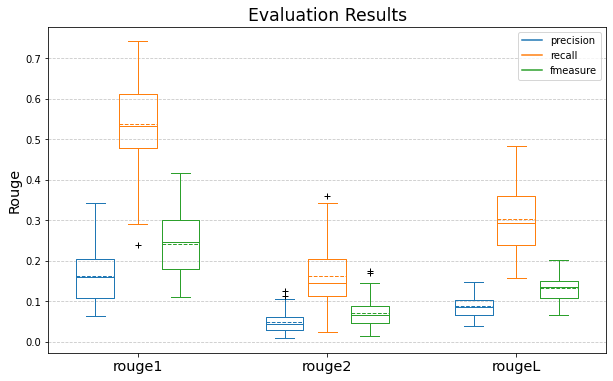

In [21]:
plot_evaluation('allenai/led-base-16384')

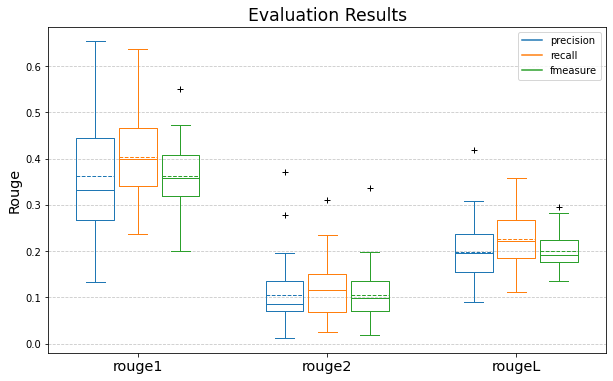

In [21]:
plot_evaluation(magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/')